<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<b>Little Demo: Light curves of cool dwarfs</b> <br>
Contact author(s): Jeff Carlin and Yumi Choi<br>
Last verified to run: 2024-01-19 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container Size: medium

Let's plot a light curve of a color-selected (red) cool dwarf star to see if it shows any variability. This is a truncated version of the DP0.2 tutorial notebook 07b, "Variable Stars in DP0.2".

## 1. Setup and Package Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service

Set up some plotting defaults so plots will look nice:

In [2]:
params = {'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 12,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook:

In [3]:
service = get_tap_service("tap")

## 2. Create a Lightcurve for a "Very Red" Star

Find objects (from the `Object` table) in a 2-degree search region with very red colors in (i-z) and (z-y). Also require them to be point-like ("extendedness = 0") and have signal-to-noise > 5.

In [9]:
query = """
SELECT 
    objectId, 
    scisql_nanojanskyToAbMag(u_psfFlux) as umag,
    scisql_nanojanskyToAbMag(g_psfFlux) as gmag, 
    scisql_nanojanskyToAbMag(r_psfFlux) as rmag,
    scisql_nanojanskyToAbMag(i_psfFlux) as imag,
    scisql_nanojanskyToAbMag(z_psfFlux) as zmag,
    scisql_nanojanskyToAbMag(y_psfFlux) as ymag
FROM dp02_dc2_catalogs.Object
WHERE 
    CONTAINS(POINT('ICRS', coord_ra, coord_dec),
    CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1 
    AND detect_isPrimary = 1 
    AND i_extendedness = 0 AND z_extendedness = 0 
    AND i_psfFlux/i_psfFluxErr > 5 
    AND z_psfFlux/z_psfFluxErr > 5 
    AND y_psfFlux/y_psfFluxErr > 5 
    AND scisql_nanojanskyToAbMag(i_psfFlux)-scisql_nanojanskyToAbMag(z_psfFlux) > 1.0 
    AND scisql_nanojanskyToAbMag(z_psfFlux)-scisql_nanojanskyToAbMag(y_psfFlux) > 1.0
"""

objects = service.search(query).to_table()


In [5]:
objects.sort('zmag')
objects

objectId,umag,gmag,rmag,imag,zmag,ymag
int64,float64,float64,float64,float64,float64,float64
1909992434935276462,27.71843360791284,27.06251782258251,25.07778942846801,22.47937198654143,21.082419777240034,19.90635729215792
1910616957539848846,--,26.87023229167988,25.309096701313784,22.74561741976364,21.330553138142378,20.15615908058814
1910265113818958967,27.691197130113025,26.97301054602859,25.722378910615593,23.14515569878916,21.76277839431919,20.581923005490864
1822093077364352264,27.656229823109022,27.530391728362854,25.793652924435648,23.558847220122736,22.149709614977674,20.964945103433756
1910045211493449980,35.86417548661043,37.31267381668704,25.976526824483685,23.95774299360061,22.431506779388844,21.296658687696677
1822532882015498892,30.039930650119494,28.82697494730207,26.88442163852535,24.02120334593114,22.65375341041908,21.528333767759797
1821574107876042279,30.54919143083693,27.665261952222295,26.721128634815614,24.11446140820055,22.686525644065245,21.524524993183228
1909579018563253617,20.665624214839852,26.88535856936572,26.33562421413773,24.412838918542683,22.709110597788065,21.17597187473248
1910141968516681274,--,28.498818205065536,26.978496553735148,24.10476297607191,22.71463968489497,21.547281572454843


Select the object ID of the brightest star returned by our color-limited search of the `Object` table, and run a search to get the forced source photometry.

In [10]:
sel_objid = objects[0]['objectId']

# Define the query
query = """
SELECT 
    src.band, src.ccdVisitId, src.coord_ra, src.coord_dec,
    src.objectId, src.psfFlux, src.psfFluxErr, 
    scisql_nanojanskyToAbMag(psfFlux) as psfMag, 
    scisql_nanojanskyToAbMagSigma(psfFlux, psfFluxErr) as psfMagErr,
    visinfo.ccdVisitId, visinfo.band, 
    visinfo.expMidptMJD, visinfo.zeroPoint
FROM dp02_dc2_catalogs.ForcedSource as src 
JOIN dp02_dc2_catalogs.CcdVisit as visinfo
ON visinfo.ccdVisitId = src.ccdVisitId
WHERE src.objectId = {}
""".format(sel_objid)

srcs = service.search(query).to_table()


In [7]:
sel_objid

1909992434935276462

Uncomment and execute the following cell to see what this table looks like.

In [ ]:
#srcs

Plot the lightcurve of the star in the all LSST filters.

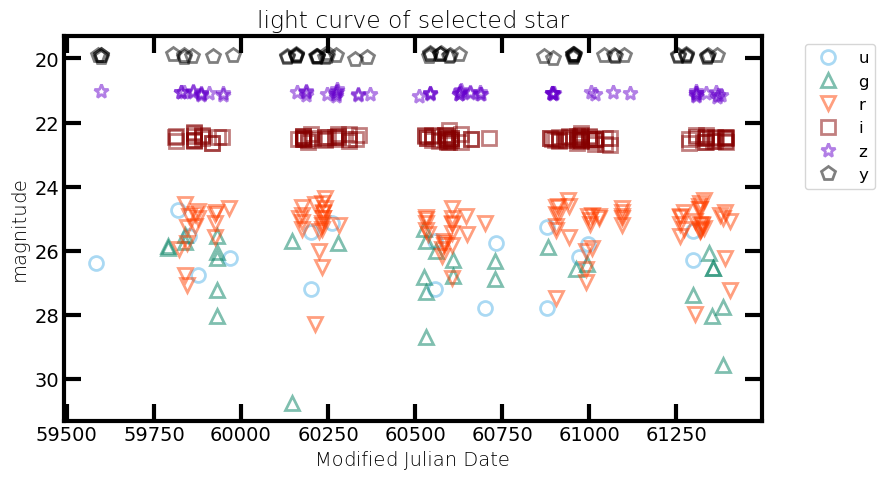

In [8]:
pick = {}
for filter in plot_filter_labels:
    pick[filter] = (srcs['band'] == filter)

fig, ax = plt.subplots(figsize=(9, 5))
    
for filter in plot_filter_labels:
    ax.plot(srcs[pick[filter]]['expMidptMJD'], srcs[pick[filter]]['psfMag'],
    plot_filter_symbols[filter], ms=10, mew=2, mec=plot_filter_colors[filter],
    alpha=0.5, color='none', label=filter)

ax.set_xlabel('Modified Julian Date')
ax.set_ylabel('magnitude')
ax.set_title('light curve of selected star')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.invert_yaxis()

plt.show()

Plot the lightcurve of the star in individual band(s) with the mean magnitude removed, including error bars on each measurement.

In [ ]:
plt.figure(figsize=(9, 5))
    
for filter in ['g', 'y']:
    mag_mean = np.nanmean(srcs[pick[filter]]['psfMag'])
    plt.errorbar(srcs[pick[filter]]['expMidptMJD'],
                 srcs[pick[filter]]['psfMag']-mag_mean,
                 yerr=srcs[pick[filter]]['psfMagErr'],
                 fmt=plot_filter_symbols[filter], ecolor='black', elinewidth=1, capsize=2,
                 ms=15, mew=1, mec=plot_filter_colors[filter],
                 alpha=1, color='none', label=filter)
    plt.hlines(0, np.min(srcs[pick[filter]]['expMidptMJD'])-100, np.max(srcs[pick[filter]]['expMidptMJD'])+100,
               linestyle=':', color='Gray')

plt.ylim(-5,5)
plt.xlabel('Modified Julian Date')
plt.ylabel(r'$\Delta mag$')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('light curve of selected star')

plt.show()

## 3. Repeat in the Portal

**Option** to execute the same query in the Portal.

3.1. Go to <a href="https://data.lsst.cloud/">data.lsst.cloud</a> in a new browser tab, and enter the Portal aspect.

3.2. In the Portal, next to “View” at the upper right, switch from the default “UI assisted” to “Edit ADQL”.

3.3. Copy and paste the following into the "ADQL Query" box.
```
SELECT 
    src.band, src.ccdVisitId, src.coord_ra, src.coord_dec,
    src.objectId, src.psfFlux, src.psfFluxErr, 
    scisql_nanojanskyToAbMag(psfFlux) as psfMag, 
    scisql_nanojanskyToAbMagSigma(psfFlux, psfFluxErr) as psfMagErr,
    visinfo.ccdVisitId, visinfo.band, 
    visinfo.expMidptMJD, visinfo.zeroPoint
FROM dp02_dc2_catalogs.ForcedSource as src 
JOIN dp02_dc2_catalogs.CcdVisit as visinfo
ON visinfo.ccdVisitId = src.ccdVisitId
WHERE src.objectId = 1909992434935276462
```

3.4. At lower left, click "Search".
The Portal will transfer to the results view, which has three components (sky coverage, xy plot, and table).

3.5. Alter the default (ra,dec) plot to be a lightcurve plot. Click on the double-gears icon at upper right to open the "Plot Parameters" pop-up window.

3.6. Change "X:" to "expMidptMJD" and "Y:" to "psfMag", check the "Error" box for the Y axis, and enter "psfMagErr" for plotting symmetric errorbars. In the Trace Options, use "zeroPoint" for the "Color Map", which allows us to differenciate filters. In the Chart Options, check the "reverse" box for the Y axis and set "Y MIN" and "Y MAX" to be 18 and 32, respectively. Finally, click on "Apply", then click on "Close".

<img src="figures/ucd-lc-portal-screenshot.png" alt="Portal screenshot with final CMD." class="bg-primary" width="800px">